 Step-1: Exploratory Data Analysis-EDA

Imports necessary Librarry

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
nltk.download('stopwords')
nltk.download('wordnet')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report




from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


cvs file detect encoding

In [2]:
import chardet


rawdata = open('/content/train.csv', 'rb').read()
result = chardet.detect(rawdata)
encoding = result['encoding']
print("Detected encoding:", encoding)

Detected encoding: MacRoman


Load Dataset

In [3]:
df = pd.read_csv('/content/train.csv', encoding=encoding, engine='python', on_bad_lines='skip')
print(df.shape)
df.head()

(404319, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404319 entries, 0 to 404318
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404319 non-null  int64 
 1   qid1          404319 non-null  int64 
 2   qid2          404319 non-null  int64 
 3   question1     404318 non-null  object
 4   question2     404317 non-null  object
 5   is_duplicate  404319 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [6]:
df.isnull().sum()

,0
id,0
qid1,0
qid2,0
question1,1
question2,2
is_duplicate,0


In [7]:
print(df.describe())

                  id           qid1           qid2   is_duplicate
count  404319.000000  404319.000000  404319.000000  404319.000000
mean   202176.517752  391846.352786  390202.073707       0.369268
std    116726.174698  228430.385343  228804.808723       0.482607
min         0.000000       1.000000       2.000000       0.000000
25%    101089.500000  193389.000000  191020.000000       0.000000
50%    202178.000000  390640.000000  388374.000000       0.000000
75%    303265.500000  589520.000000  588081.000000       1.000000
max    404350.000000  789800.000000  789801.000000       1.000000


In [8]:
df.dropna(inplace=True)

Visualize Distribution of Target Variable

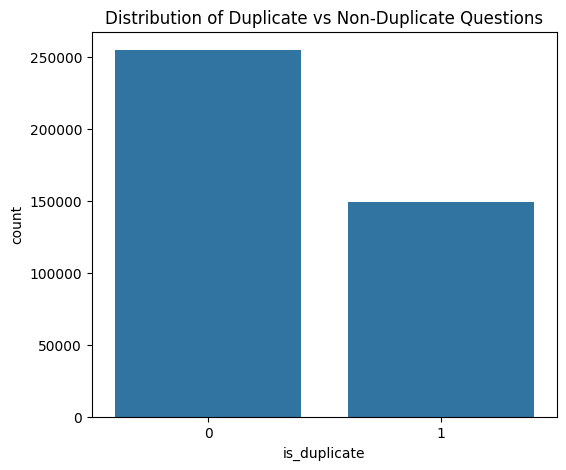

Duplicate questions: 36.93%


In [9]:
plt.figure(figsize=(6,5))
sns.countplot(data= df, x='is_duplicate')
plt.title("Distribution of Duplicate vs Non-Duplicate Questions")
plt.show()

duplicate_percentage = df['is_duplicate'].mean()*100
print(f"Duplicate questions: {duplicate_percentage:.2f}%")

Text Length Analysis

 analyze sentence length by number of words and number of characters.

In [10]:
df['q1_len'] = df['question1'].apply(lambda x: len(str(x).split()))
df['q2_len'] = df['question2'].apply(lambda x: len(str(x).split()))

df['q1_char'] = df['question1'].apply(lambda x: len(str(x)))
df['q2_char'] = df['question2'].apply(lambda x: len(str(x)))


Text Length Distribution

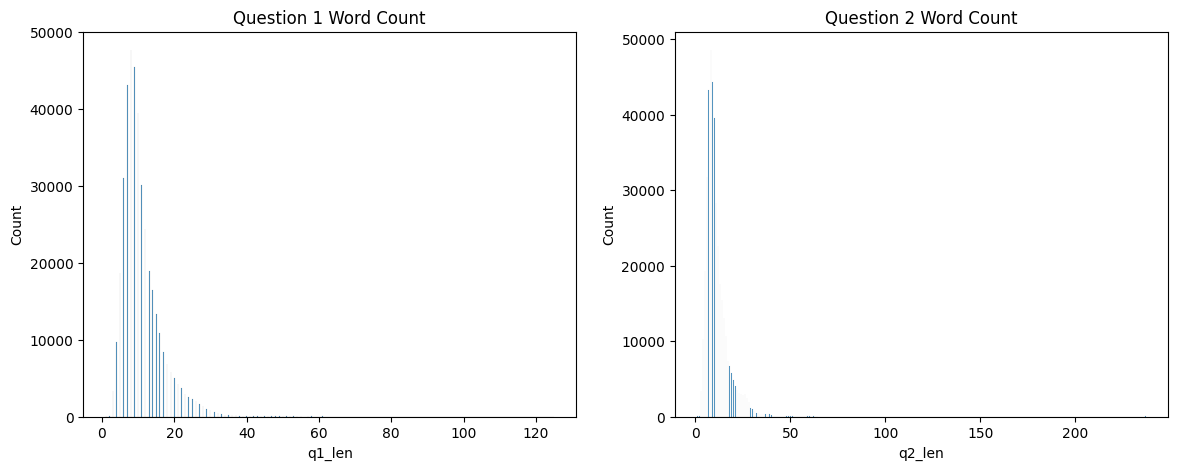

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))
sns.histplot(df['q1_len'], ax=axes[0])
axes[0].set_title("Question 1 Word Count")
sns.histplot(df['q2_len'], ax=axes[1])
axes[1].set_title("Question 2 Word Count")
plt.show()


Compare Duplicate vs Non-Duplicate

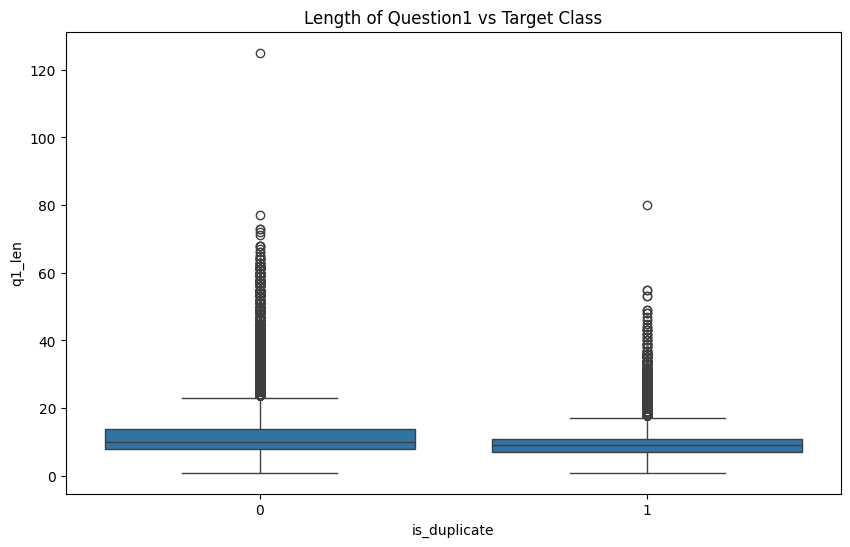

In [12]:
plt.figure(figsize=(10,6))
sns.boxplot(x='is_duplicate', y='q1_len', data=df)
plt.title("Length of Question1 vs Target Class")
plt.show()


Word Cloud Analysis

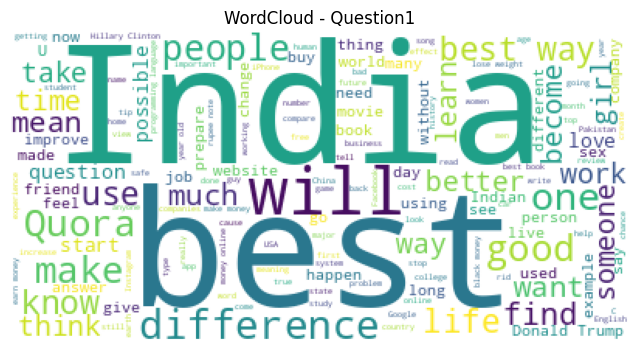

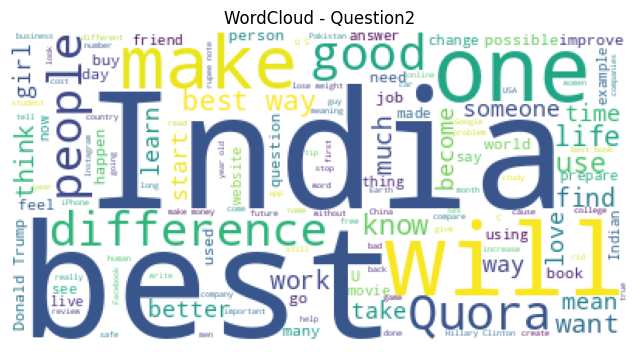

In [13]:
stop_words = set(STOPWORDS)

def create_wordcloud(text, title):
    wordcloud = WordCloud(stopwords=stop_words, background_color='white', max_words=200)
    wordcloud.generate(" ".join(text))
    plt.figure(figsize=(8,6))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.show()

create_wordcloud(df['question1'], "WordCloud - Question1")
create_wordcloud(df['question2'], "WordCloud - Question2")

Correlation Analysis (Feature Engineering Preview)

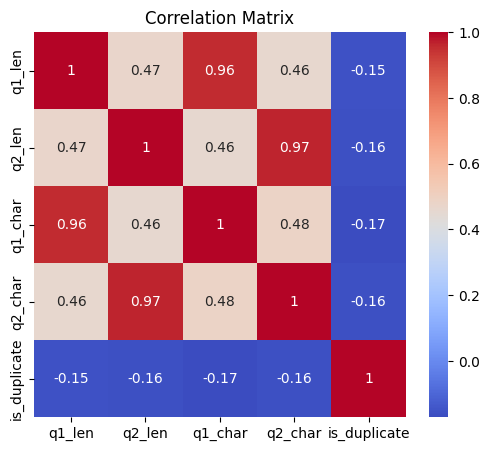

In [14]:
plt.figure(figsize=(6,5))
sns.heatmap(df[['q1_len', 'q2_len', 'q1_char', 'q2_char', 'is_duplicate']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


Step-2 Text Processing

 - Lowercasing
 - Removing special characters & numbers
 - Removing stopwords
 - Lemmatization

In [15]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Remove special characters, numbers, punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize & remove stopwords + lemmatize words
    tokens = [lemmatizer.lemmatize(word)
              for word in text.split()
              if word not in stop_words]

    return " ".join(tokens)


Apply Preprocessing to Both Questions

In [16]:
df['q1_clean'] = df['question1'].apply(preprocess_text)
df['q2_clean'] = df['question2'].apply(preprocess_text)
df[['question1', 'q1_clean', 'question2', 'q2_clean']].head()


,question1,q1_clean,question2,q2_clean
0,What is the step by step guide to invest in sh...,step step guide invest share market india,What is the step by step guide to invest in sh...,step step guide invest share market
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,story kohinoor kohinoor diamond,What would happen if the Indian government sto...,would happen indian government stole kohinoor ...
2,How can I increase the speed of my internet co...,increase speed internet connection using vpn,How can Internet speed be increased by hacking...,internet speed increased hacking dns
3,Why am I mentally very lonely? How can I solve...,mentally lonely solve,Find the remainder when [math]23^{24}[/math] i...,find remainder mathmath divided
4,"Which one dissolve in water quikly sugar, salt...",one dissolve water quikly sugar salt methane c...,Which fish would survive in salt water?,fish would survive salt water


Combine Both Questions into a Single Feature

 -ML models expect one representation per sample.

In [17]:
df['combined_text'] = df['q1_clean'] + " " + df['q2_clean']


TF-IDF Feature Extrection

In [18]:
#tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1,2))

#X = tfidf.fit_transform(df['combined_text']).toarray()
#y = df['is_duplicate']


In [19]:
tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1,2))
q1_tfidf = tfidf.fit_transform(df['q1_clean'])
q2_tfidf = tfidf.transform(df['q2_clean'])

# Combine features by absolute difference or concatenation
from scipy.sparse import hstack

X = hstack((q1_tfidf, q2_tfidf))
y = df['is_duplicate']



Using TensorFlow/Keras

In [20]:

import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Data
X = df  # uses df from preprocessing step
y = df['is_duplicate'].values

# train/val split (stratify to preserve class balance)
df, df = train_test_split(df, test_size=0.15, random_state=42, stratify=df['is_duplicate'])

1) Baseline — Logistic Regression on TF-IDF

In [21]:
tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1,2))

pipeline = Pipeline([
    ('tfidf', tfidf),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

pipeline.fit(df['combined_text'], df['is_duplicate'])
val_preds = pipeline.predict(df['combined_text'])

print("Baseline Logistic Regression")
print(classification_report(df['is_duplicate'], val_preds, digits=4))

Baseline Logistic Regression
              precision    recall  f1-score   support

           0     0.8713    0.8219    0.8459     38252
           1     0.7227    0.7926    0.7560     22396

    accuracy                         0.8111     60648
   macro avg     0.7970    0.8072    0.8009     60648
weighted avg     0.8164    0.8111    0.8127     60648



2. Siamese LSTM

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_VOCAB = 50000
MAX_LEN = 40   # typical question length; adjust if needed
EMBED_DIM = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df['combined_text'])

def texts_to_padded_sequences(texts):
    seq = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')

X_train_seq = texts_to_padded_sequences(df['combined_text'])
X_val_seq   = texts_to_padded_sequences(df['combined_text'])
y_train = df['is_duplicate'].values
y_val   = df['is_duplicate'].values

# Simple LSTM model
inp = Input(shape=(MAX_LEN,))
x = layers.Embedding(input_dim=MAX_VOCAB, output_dim=EMBED_DIM, input_length=MAX_LEN)(inp)
x = layers.SpatialDropout1D(0.2)(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
out = layers.Dense(1, activation='sigmoid')(x)

model_lstm = Model(inputs=inp, outputs=out)
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
model_lstm.summary()

# Callbacks
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
chk = ModelCheckpoint('lstm_best.h5', save_best_only=True, monitor='val_loss')

# Train (use class weights)
from sklearn.utils import class_weight
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: cw[i] for i in range(len(cw))}

history = model_lstm.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=8,
    batch_size=256,
    class_weight=class_weights,
    callbacks=[es, chk]
)

# Evaluate
val_probs = model_lstm.predict(X_val_seq).ravel()
val_preds = (val_probs >= 0.5).astype(int)

print("LSTM performance:")
print(classification_report(y_val, val_preds, digits=4))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 40, 100)        │     5,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 40, 100)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,093,313 (19.43 MB)

 Trainable params: 5,093,057 (19.43 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/8
234/237 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.6973 - loss: 0.6279

237/237 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - AUC: 0.6980 - loss: 0.6273 - val_AUC: 0.8570 - val_loss: 0.6537
Epoch 2/8
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.8528 - loss: 0.4779

237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - AUC: 0.8528 - loss: 0.4779 - val_AUC: 0.9230 - val_loss: 0.4940
Epoch 3/8
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9142 - loss: 0.3705

237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - AUC: 0.9142 - loss: 0.3706 - val_AUC: 0.9567 - val_loss: 0.3072
Epoch 4/8
236/237 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.9443 - loss: 0.2973

237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - AUC: 0.9443 - loss: 0.2974 - val_AUC: 0.9646 - val_loss: 0.2567
Epoch 5/8
236/237 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9620 - loss: 0.2439

237/237 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - AUC: 0.9620 - loss: 0.2440 - val_AUC: 0.9824 - val_loss: 0.2062
Epoch 6/8
236/237 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.9728 - loss: 0.2042

237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - AUC: 0.9727 - loss: 0.2043 - val_AUC: 0.9853 - val_loss: 0.1589
Epoch 7/8
235/237 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9795 - loss: 0.1755

237/237 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - AUC: 0.9795 - loss: 0.1757 - val_AUC: 0.9901 - val_loss: 0.1348
Epoch 8/8
236/237 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9837 - loss: 0.1559

237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - AUC: 0.9837 - loss: 0.1560 - val_AUC: 0.9920 - val_loss: 0.1202
1896/1896 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
LSTM performance:
              precision    recall  f1-score   support

           0     0.9837    0.9372    0.9599     38252
           1     0.9008    0.9735    0.9358     22396

    accuracy                         0.9506     60648
   macro avg     0.9423    0.9554    0.9478     60648
weighted avg     0.9531    0.9506    0.9510     60648



4) Using pretrained embeddings (GloVe) — quick instructions

In [23]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding
import numpy as np

MAX_VOCAB = 30000
EMBED_DIM = 100

# Tokenizer
tokenizer_siam = Tokenizer(num_words=MAX_VOCAB)
tokenizer_siam.fit_on_texts(df['question1'].astype(str).tolist() +
                            df['question2'].astype(str).tolist())

# Load GloVe
emb_index = {}
with open('/content/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        try:
            vect = np.asarray(values[1:], dtype='float32')
            if len(vect) == EMBED_DIM:   # only accept correct shape
                emb_index[word] = vect
        except ValueError:
            continue

# Embedding matrix
word_index = tokenizer_siam.word_index
embedding_matrix = np.zeros((min(MAX_VOCAB, len(word_index)+1), EMBED_DIM))
for word, i in word_index.items():
    if i >= MAX_VOCAB:
        continue
    vec = emb_index.get(word)
    if vec is not None:
        embedding_matrix[i] = vec


Transfer learning with BERT / DistilBERT (outline)

In [24]:
!pip install transformers datasets accelerate torch --quiet


In [25]:
import pandas as pd


df = df[['q1_clean','q2_clean','is_duplicate']].dropna()
df.head()


,q1_clean,q2_clean,is_duplicate
87374,would win fight temari shikamaru,would win fight temari shikamaru,1
83519,best phone buy r,best phone india,1
71495,thank people following quora,dont people follow quora,0
40553,craziest place sex,oddest place youve sex,1
5029,computer programming make electronic assistant...,make virtual assistant like guile denise siri ...,0


In [26]:
from transformers import AutoTokenizer

MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(example):
    return tokenizer(
        example['q1_clean'],
        example['q2_clean'],
        truncation=True,
        padding='max_length',
        max_length=128
    )


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [48]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)
dataset = dataset.class_encode_column("is_duplicate")

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("is_duplicate", "labels")
tokenized_dataset = tokenized_dataset.remove_columns(['q1_clean','q2_clean','__index_level_0__'])
tokenized_dataset.set_format("torch")


Stringifying the column:   0%|          | 0/60648 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/60648 [00:00<?, ? examples/s]

Map:   0%|          | 0/60648 [00:00<?, ? examples/s]

In [49]:
split = tokenized_dataset.train_test_split(test_size=0.1)
train_dataset = split['train']
eval_dataset = split['test']


In [50]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
).to('cuda')


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
!pip install --upgrade transformers datasets accelerate --quiet


In [51]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds)
    }

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=50
)




In [52]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.416000,0.395782,0.806925,0.762137
2,0.331900,0.396263,0.824897,0.773754


TrainOutput(global_step=6824, training_loss=0.386577004844111, metrics={'train_runtime': 1214.3061, 'train_samples_per_second': 89.9, 'train_steps_per_second': 5.62, 'total_flos': 3615234010420224.0, 'train_loss': 0.386577004844111, 'epoch': 2.0})

In [53]:
trainer.evaluate()


{'eval_loss': 0.39626315236091614,
 'eval_accuracy': 0.8248969497114592,
 'eval_f1': 0.7737537281636131,
 'eval_runtime': 23.4565,
 'eval_samples_per_second': 258.564,
 'eval_steps_per_second': 16.2,
 'epoch': 2.0}

AUC-ROC Curve

Measures how well model distinguishes duplicate vs non-duplicate pairs.

📊 Model Evaluation Results:
Accuracy: 0.8248969497114592
Precision: 0.7385115900772672
Recall: 0.8125279642058165
F1 Score: 0.7737537281636131
ROC-AUC Score: 0.9021524406983605


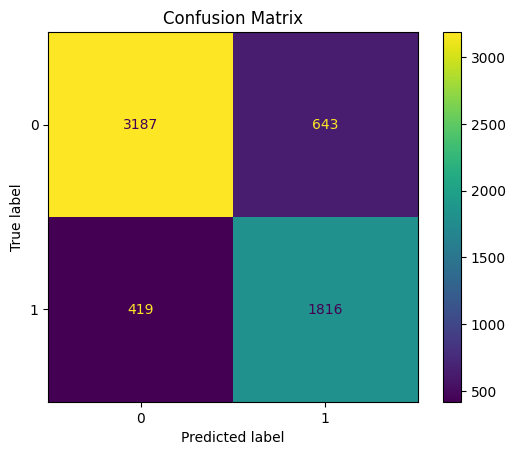

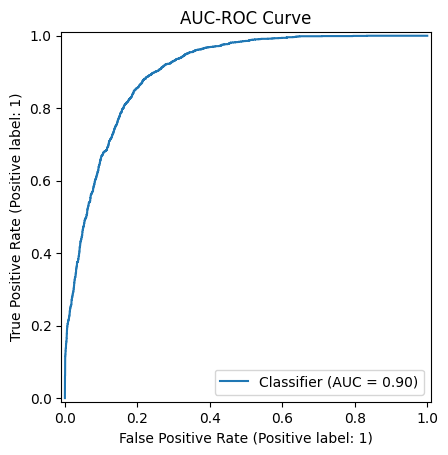

In [61]:

import torch

# Compute predictions
preds_output = trainer.predict(eval_dataset)
logits = preds_output.predictions
probs = torch.softmax(torch.tensor(logits), dim=1)[:,1].numpy()  # probability of class 1
y_pred_flat = (probs > 0.5).astype(int)
y_test_flat = np.array(eval_dataset['labels'])

# Metrics
accuracy = accuracy_score(y_test_flat, y_pred_flat)
precision = precision_score(y_test_flat, y_pred_flat)
recall = recall_score(y_test_flat, y_pred_flat)
f1 = f1_score(y_test_flat, y_pred_flat)
roc_auc = roc_auc_score(y_test_flat, probs)

print("📊 Model Evaluation Results:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC-AUC Score:", roc_auc)

# Confusion Matrix
cm = confusion_matrix(y_test_flat, y_pred_flat)
ConfusionMatrixDisplay(cm).plot()
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test_flat, probs)
plt.title("AUC-ROC Curve")
plt.show()


Using Keras Tuner for LSTM

In [67]:

!pip install keras-tuner -q

from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from tensorflow.keras import metrics

class LSTMHyperModel(HyperModel):
    def build(self, hp):
        inp = Input(shape=(MAX_LEN,))
        x = layers.Embedding(input_dim=MAX_VOCAB, output_dim=EMBED_DIM, input_length=MAX_LEN)(inp)
        x = layers.SpatialDropout1D(0.2)(x)
        x = layers.Bidirectional(
            layers.LSTM(hp.Int('lstm_units', min_value=32, max_value=128, step=32))
        )(x)
        x = layers.Dense(hp.Int('dense_units', 32, 128, step=32), activation='relu')(x)
        x = layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1))(x)
        out = layers.Dense(1, activation='sigmoid')(x)

        optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])
        model = Model(inp, out)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[metrics.AUC(name='val_auc')])
        return model

hypermodel = LSTMHyperModel()

tuner = RandomSearch(
    hypermodel,
    objective='val_auc',
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='quora_similarity'
)

tuner.search(X_train_seq, y_train, epochs=5, batch_size=256,
             validation_data=(X_val_seq, y_val))


Trial 10 Complete [00h 00m 34s]
val_auc: 0.8407852649688721

Best val_auc So Far: 0.9503382444381714
Total elapsed time: 00h 20m 26s


Manual Hyperparameter Tuning

In [68]:
def create_lstm_model(lstm_units=64, dense_units=64, dropout=0.3, optimizer='adam'):
    inp = Input(shape=(MAX_LEN,))
    x = layers.Embedding(input_dim=MAX_VOCAB, output_dim=EMBED_DIM, input_length=MAX_LEN)(inp)
    x = layers.Bidirectional(layers.LSTM(lstm_units))(x)
    x = layers.Dense(dense_units, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inp, out)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['AUC'])
    return model

# Example: try 128 LSTM units + 0.5 dropout
model = create_lstm_model(lstm_units=128, dropout=0.5)
history = model.fit(X_train_seq, y_train, validation_data=(X_val_seq, y_val),
                    epochs=10, batch_size=128, class_weight=class_weights,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3)])


Epoch 1/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - AUC: 0.6976 - loss: 0.6231 - val_AUC: 0.8558 - val_loss: 0.4972
Epoch 2/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - AUC: 0.8378 - loss: 0.4974 - val_AUC: 0.9006 - val_loss: 0.4015
Epoch 3/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - AUC: 0.9100 - loss: 0.3755 - val_AUC: 0.9172 - val_loss: 0.3664
Epoch 4/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 0.9456 - loss: 0.2860 - val_AUC: 0.9249 - val_loss: 0.3668
Epoch 5/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 0.9615 - loss: 0.2358 - val_AUC: 0.9201 - val_loss: 0.4245
Epoch 6/10
474/474 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 0.9702 - loss: 0.2066 - val_AUC: 0.9203 - val_loss: 0.4262


Evaluating After Tuning

In [69]:
y_val_pred = (model.predict(X_val_seq) >= 0.5).astype(int)
print(classification_report(y_val, y_val_pred, digits=4))


1896/1896 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step
              precision    recall  f1-score   support

           0     0.8961    0.8598    0.8776     38252
           1     0.7761    0.8298    0.8020     22396

    accuracy                         0.8487     60648
   macro avg     0.8361    0.8448    0.8398     60648
weighted avg     0.8518    0.8487    0.8497     60648

